### Data Info
The sample data are 4005 resting-state functional connectivity between 90 pairs of cortical regions based on FindLab's atlas.

The data are from 648 subjects (360 controls and 288 PTSD patients) in 5 sites aggregated by the PGC ENIGMA PTSD project.

The data were preprocessed using ComBat-GAM to remove the site effects while preserving the biologically relevant information including PTSD diagnosis, age, and sex. The nonlinear trend of age was also considered by ComBat-GAM.

The aim of this script is to use resting-state functional connectivity to classify people with and without PTSD.

In [101]:
# Load packages
import pandas as pd
import numpy as np

# Load data
fname = "..\\Output\\FindLab90\\timeseries_PTSD\\All_harmonized.csv"
df = pd.read_csv(fname, )
df.head()

,fID,SiteName,SITE,Group,NewGroup,Age,Sex,V1,V2,V3,...,V3996,V3997,V3998,V3999,V4000,V4001,V4002,V4003,V4004,V4005
0,AMC_1132,BOOSTER study,6,-1,-1,29.0,1,0.781764,0.617034,0.303107,...,0.222468,0.265792,0.206213,0.024372,0.112773,-0.047370,0.184605,0.115313,0.685608,0.048506
1,AMC_1133,BOOSTER study,6,-1,-1,57.0,1,0.461970,0.568129,0.424011,...,0.263550,0.064922,-0.024707,0.103043,0.036448,0.299417,0.228011,0.009992,0.129018,0.273513
2,AMC_1134,BOOSTER study,6,-1,-1,28.0,1,0.573399,0.661576,0.473030,...,0.441894,0.429557,0.262698,0.541580,-0.162284,0.228165,0.229438,0.714528,0.582166,0.373303
3,AMC_1135,BOOSTER study,6,-1,-1,37.0,1,0.611681,0.219745,0.174806,...,0.609247,0.335831,0.203155,0.677713,0.219033,0.158510,0.407728,0.296747,0.277458,0.477866
4,AMC_1136,BOOSTER study,6,-1,-1,45.0,1,0.730630,0.455293,0.433711,...,0.464991,0.729394,0.556331,0.271449,0.563293,0.617926,0.705818,0.500628,0.286663,0.506800


### Label Encoder

In [102]:
from sklearn.preprocessing import LabelEncoder
X = df.iloc[:, 8:].values # data are 4005 resting-state functional connections between 90 pairs of cortical regions
y = df.iloc[:, 4].values # group labels, -1=control, 1&2=PTSD
y[y>-1] = 1 # 1 and 2 -> 1
# show the number of subjects per group
uniq, counts = np.unique(y, return_counts=True)
np.asarray([uniq, counts]).T

array([[ -1, 360],
       [  1, 288]], dtype=int64)

In [103]:
le = LabelEncoder()
y = le.fit_transform(y)
le.transform([-1, 1]) # now 0=Control, 1=PTSD

array([0, 1], dtype=int64)

### Train Test Split

In [104]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1) # ??? random_state

### Pipeline

##### Packages related to pipeline

In [105]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

##### Pipeline: LogisticRegression

In [106]:
pipe_lr = Pipeline([('scl', StandardScaler()),
                   ('pca', PCA(n_components=3)),
                   ('clf', LogisticRegression(random_state=1))])
pipe_lr.fit(X_train, y_train)
print("test accuracy: %.3f" % pipe_lr.score(X_test, y_test))
y_predict = pipe_lr.predict(X_test)

test accuracy: 0.585


###### K-folder corss-validation

In [107]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(estimator=pipe_lr, X=X_train, y=y_train, cv=10, n_jobs=1) # ??? n_jobs meaning
print("Cross validation accuracy scores: %s" % scores)
print("Cross validation accuracy: %.3f +/- %.3f" % (np.mean(scores), np.std(scores)))

Cross validation accuracy scores: [0.57692308 0.57692308 0.55769231 0.57692308 0.53846154 0.57692308
 0.57692308 0.53846154 0.54901961 0.49019608]
Cross validation accuracy: 0.556 +/- 0.027


### Hyper-parameters

##### Learning curve: accuracy ~ number of sample

In [115]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

pipe_lr = Pipeline([('scl', StandardScaler()),
                   ('pca', PCA(n_components=8)),
                   ('clf', LogisticRegression(penalty='l2', C=1, random_state=1))]) # ??? pca need or not? l2 or l1 penalty?

train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_lr, X=X_train, y=y_train, train_sizes=np.linspace(0.1, 1, 10), cv=5, n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std  = np.std(train_scores, axis=1)
test_mean  = np.mean(test_scores, axis=1)
test_std   = np.std(test_scores, axis=1)

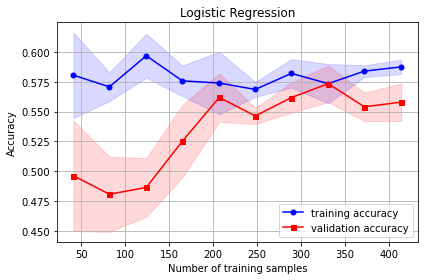

In [116]:
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label="training accuracy")
plt.fill_between(train_sizes, train_mean+train_std, train_mean-train_std, alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, color='red', marker='s', markersize=5, label="validation accuracy")
plt.fill_between(train_sizes, test_mean+test_std, test_mean-test_std, alpha=0.15, color='red')

plt.grid()
plt.title('Logistic Regression')
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
#plt.ylim([0.8, 1.0])
plt.tight_layout()
plt.show()

##### validation curve: accuracy ~ Parameter C

In [110]:
from sklearn.model_selection import validation_curve

param_range = [0.001, 0.01, 0.1, 1, 10, 100]
train_scores, test_scores = validation_curve(estimator=pipe_lr, X=X_train, y=y_train, param_name='clf__C', param_range=param_range, cv=10)
train_mean = np.mean(train_scores, axis=1)
train_std  = np.std(train_scores, axis=1)
test_mean  = np.mean(test_scores, axis=1)
test_std   = np.std(test_scores, axis=1)

In [113]:
print('Parameters that could be changed:')
pipe_lr.get_params()

Parameters that could be changed:


{'memory': None,
 'steps': [('scl', StandardScaler()),
  ('pca', PCA(n_components=2)),
  ('clf', LogisticRegression(C=0.1, random_state=1))],
 'verbose': False,
 'scl': StandardScaler(),
 'pca': PCA(n_components=2),
 'clf': LogisticRegression(C=0.1, random_state=1),
 'scl__copy': True,
 'scl__with_mean': True,
 'scl__with_std': True,
 'pca__copy': True,
 'pca__iterated_power': 'auto',
 'pca__n_components': 2,
 'pca__random_state': None,
 'pca__svd_solver': 'auto',
 'pca__tol': 0.0,
 'pca__whiten': False,
 'clf__C': 0.1,
 'clf__class_weight': None,
 'clf__dual': False,
 'clf__fit_intercept': True,
 'clf__intercept_scaling': 1,
 'clf__l1_ratio': None,
 'clf__max_iter': 100,
 'clf__multi_class': 'auto',
 'clf__n_jobs': None,
 'clf__penalty': 'l2',
 'clf__random_state': 1,
 'clf__solver': 'lbfgs',
 'clf__tol': 0.0001,
 'clf__verbose': 0,
 'clf__warm_start': False}

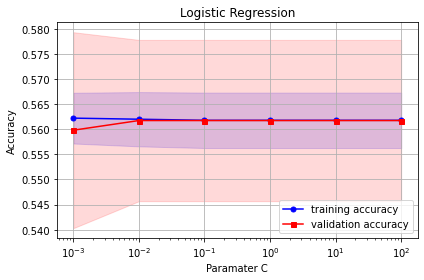

In [112]:
plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5, label="training accuracy")
plt.fill_between(param_range, train_mean+train_std, train_mean-train_std, alpha=0.15, color='blue')

plt.plot(param_range, test_mean, color='red', marker='s', markersize=5, label="validation accuracy")
plt.fill_between(param_range, test_mean+test_std, test_mean-test_std, alpha=0.15, color='red')

plt.grid()
plt.xscale('log')
plt.title('Logistic Regression')
plt.xlabel('Paramater C')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
#plt.ylim([0.8, 1.0])
plt.tight_layout()
plt.show()

##### grid search

In [114]:
from sklearn.model_selection import GridSearchCV

param_range_C = [0.001, 0.01, 0.1, 1, 10, 100]
param_range_pca_n_components = [2, 3, 4, 5, 6, 7, 8]

param_grid = [{'clf__C':param_range_C,
              'pca__n_components':param_range_pca_n_components}]

gs = GridSearchCV(estimator=pipe_lr, param_grid=param_grid, scoring='accuracy', cv=10, n_jobs=-1) # ??? n_jobs=-1?
gs = gs.fit(X_train, y_train)
print('Grid Search Best Score = ' % gs.best_score_)
print('Grid Search Best parameters:')
print(gs.best_params_)

Grid Search Best Score = 
Grid Search Best parameters:
{'clf__C': 1, 'pca__n_components': 8}
